# Data Exploration

This is a time series prediction, so we want to see how the full data (train + test) evolves over time. We want to make this project object oriented so that we can simply replace the files for data analytics and the system should work. First we need to do some exploration of the data. We have a number of different regions we can look at, we can explore each one individually by declaring the data at the top. 

Column values
- 
Applicable At: Time in which data was generat
- 	
Applicable For: Date in which data is representing (this is the column to pull dates fr
- m)
Data Item: Description of data, region, time 
- c. 
Value: Gas demand value measured in MCM (million cubic me
- ers)
Generated Time: Similar to Applicable Time (possibly when publ
- shed)
Quality Indicator: This indicates when there is duplicate data, which I have removed. The L value indicates the the data was late to be published



In [38]:
import pandas as pd

In [39]:
demand_data = pd.read_csv("../data/raw/demand_data/GDUK_EAST_ANGLIA.csv")

In [40]:
demand_data.columns

Index(['Applicable At', 'Applicable For', 'Data Item', 'Value',
       'Generated Time', 'Quality Indicator'],
      dtype='object')

It looks like all the data is here, the quality indicator shows when the data has been corrected or amended post uploading to the system.

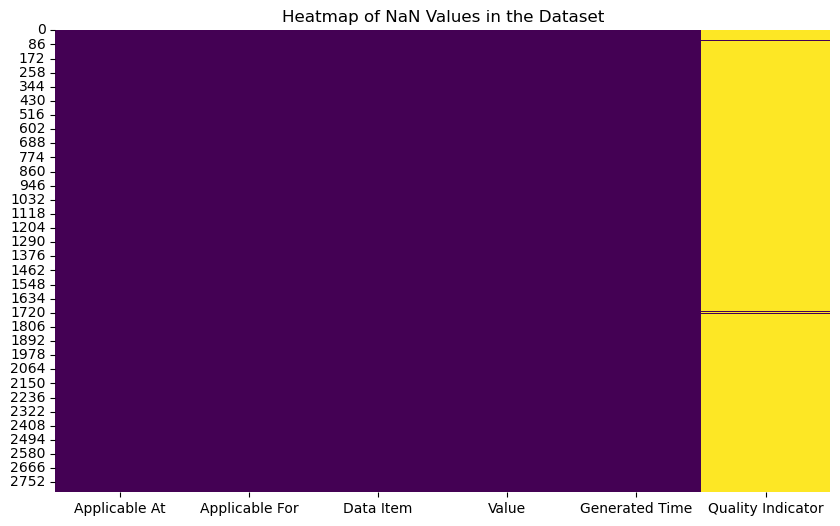

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize missing values (NaNs)
plt.figure(figsize=(10, 6))
sns.heatmap(demand_data.isna(), cbar=False, cmap='viridis')
plt.title('Heatmap of NaN Values in the Dataset')
plt.show()


In [42]:
import plotly.express as px
import plotly.graph_objects as go


First we can look at the actul time series for the gas demand, it looks like there is a real seasonal spread to the data with winter and summer.

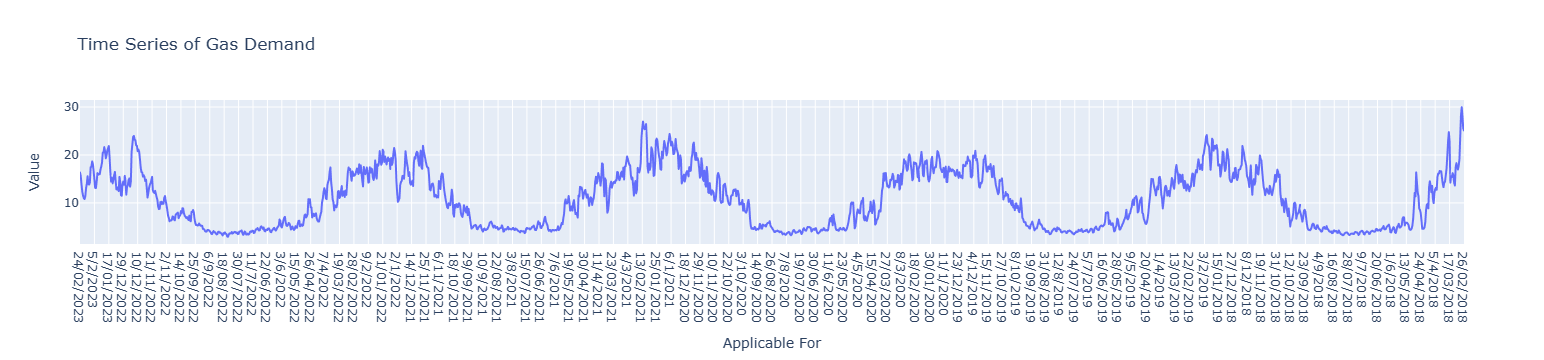

In [43]:
# 1. Time Series Plot for a selected store (store 0 as an example)
ts_plot = px.line(demand_data, x='Applicable For', y='Value',
                  title='Time Series of Gas Demand')

# Display plots
ts_plot.show()


Histogram of the data

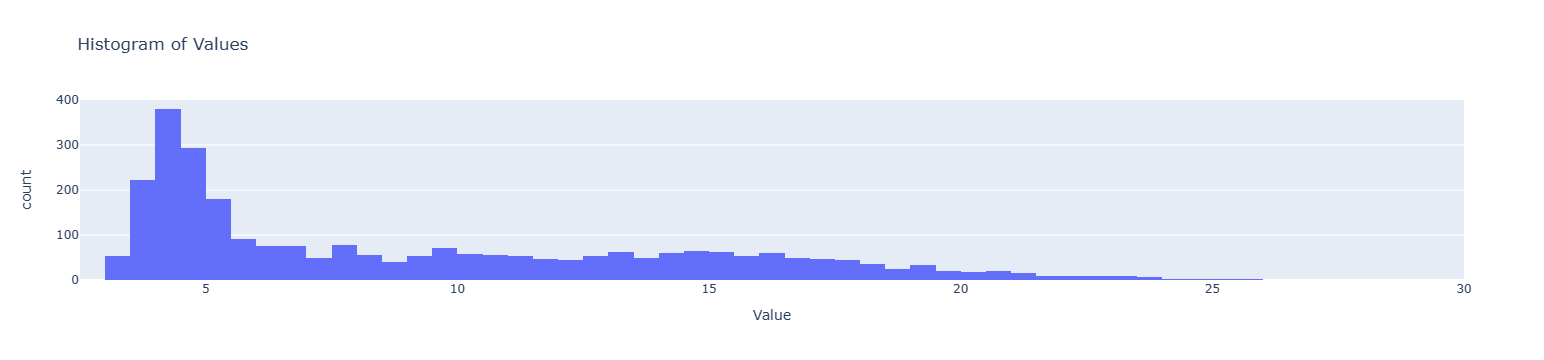

In [44]:
# Histogram for the numerical 'Value' column
hist_value = px.histogram(demand_data, x='Value', title='Histogram of Values')
hist_value.show()

My suspicion is that it is closely correlated with weather data. If I pull in the weather data for a grid taht is in the EAST ANGLIA region I think there will be a trend.

In [45]:
weather_data = pd.read_csv("../data/raw/noaa/51.50000_-0.50000.csv")

In [52]:
# Convert the 'date' column in weather_data to datetime to match the 'Applicable For' in demand_data
weather_data['date'] = pd.to_datetime(weather_data['date'])
demand_data['Applicable For'] = pd.to_datetime(demand_data['Applicable For'], dayfirst=True)
merged_data = pd.merge(weather_data, demand_data, left_on='date', right_on='Applicable For', how='inner')
merged_data = merged_data[merged_data['airTemperature_min'] > -10] #Was a value of -80 degrees which was clearly an error

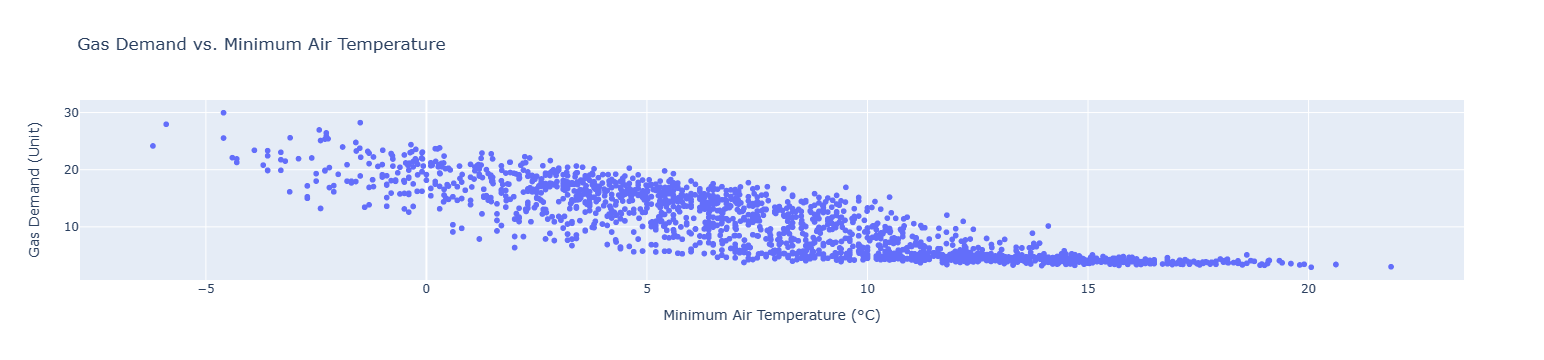

In [55]:
# Create a scatter plot of Demand vs. Minimum Air Temperature
fig = px.scatter(merged_data, x='airTemperature_min', y='Value', 
                 title='Gas Demand vs. Minimum Air Temperature',
                 labels={'airTemperature_min': 'Minimum Air Temperature (°C)', 'Value': 'Gas Demand (Unit)'})  # Adding a trendline to see the relationship pattern

fig.show()


Somewhat of a negative correlation, let's see timeseries.

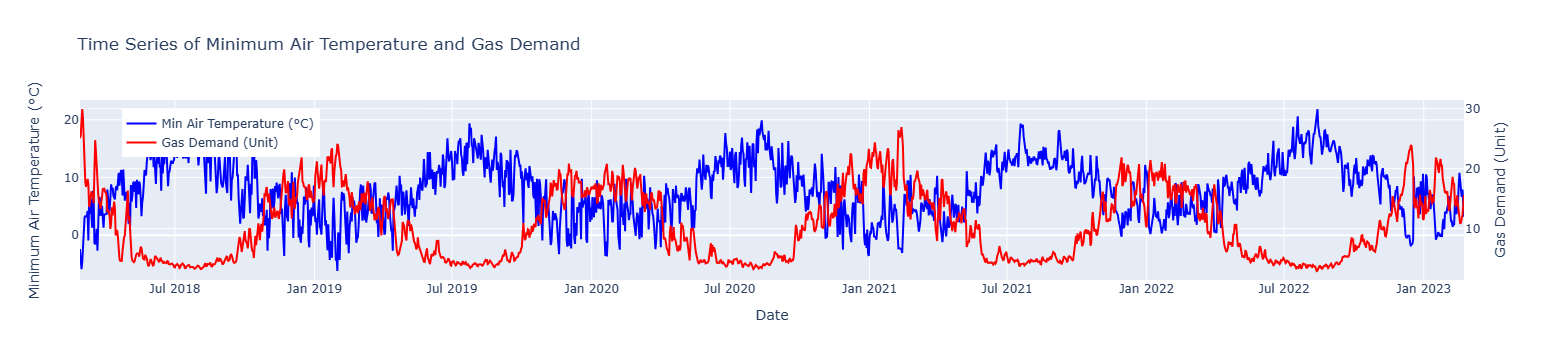

In [62]:
import plotly.graph_objects as go

# Create a figure with secondary y-axis
fig = go.Figure()

# Add traces
fig.add_trace(
    go.Scatter(x=merged_data['date'], y=merged_data['airTemperature_min'], name="Min Air Temperature (°C)", 
               mode='lines', line=dict(color='blue'))
)

fig.add_trace(
    go.Scatter(x=merged_data['date'], y=merged_data['Value'], name="Gas Demand (Unit)", 
               mode='lines', line=dict(color='red'), yaxis='y2')
)

# Create axis objects
fig.update_layout(
    title="Time Series of Minimum Air Temperature and Gas Demand",
    xaxis_title="Date",
    yaxis=dict(
        title="Minimum Air Temperature (°C)",
    ),
    yaxis2=dict(
        title="Gas Demand (Unit)",
        anchor="free",
        overlaying="y",
        side="right",
        position=1
    ),
    legend=dict(x=0.03, y=0.95),
)

# Show the figure
fig.show()


I wonder what the values looks like per day. On doing some research the demand is driven by someone with a valve that lets gas into the system based on temperature. I wonder what a linear regresssion would look like on a given day over a number of years.

In [84]:
merged_data['day_of_year'] = merged_data['date'].dt.dayofyear

day = 310

# Filter the dataset for day of the year = 35
filtered_data = merged_data[merged_data['day_of_year'] == day]

# Display the filtered data to confirm
filtered_data[['date', 'day_of_year', 'airTemperature_min', 'Value']]

,date,day_of_year,airTemperature_min,Value
473,2018-11-06,310,7.20,11.6225
1055,2019-11-06,310,2.50,14.9969
1632,2020-11-05,310,-0.10,16.2335
2213,2021-11-06,310,6.65,12.8903
2702,2022-11-06,310,10.43,9.8186


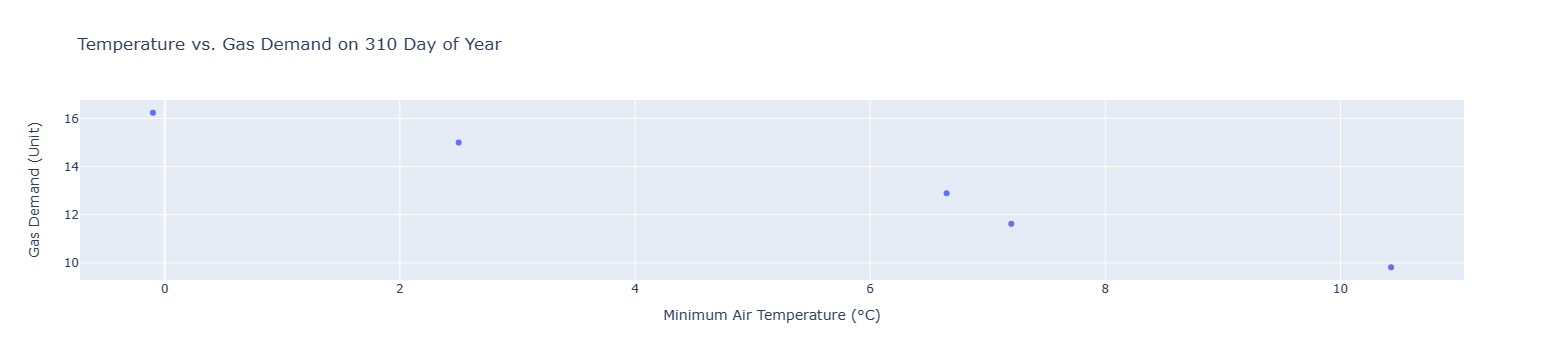

In [85]:
# Create an XY plot of temperature vs. demand for the filtered data
fig = px.scatter(filtered_data, x='airTemperature_min', y='Value', 
                 title=f'Temperature vs. Gas Demand on {day} Day of Year',
                 labels={'airTemperature_min': 'Minimum Air Temperature (°C)', 'Value': 'Gas Demand (Unit)'})  # Adding a trendline to see the relationship pattern

fig.show()


There does seem to be a negative correlation. I do wonder whether the operators reduce the demand in the system based on increasing temperature. Seems to be negative in winter flat in summer.

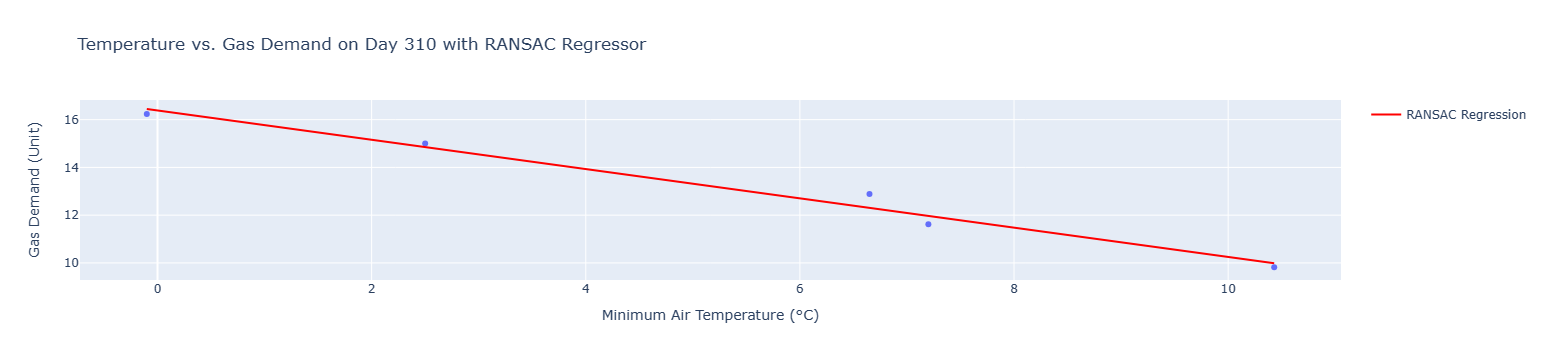

In [86]:
from sklearn.linear_model import RANSACRegressor
import numpy as np

# Prepare data for the RANSAC regressor
X = filtered_data['airTemperature_min'].values.reshape(-1, 1)
y = filtered_data['Value'].values

# Initialize and fit the RANSAC regressor
ransac = RANSACRegressor()
ransac.fit(X, y)

# Predict values using the fitted model
x_range = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_pred = ransac.predict(x_range)

# Create a Plotly figure and add the original scatter plot
fig = px.scatter(filtered_data, x='airTemperature_min', y='Value', 
                 title=f'Temperature vs. Gas Demand on Day {day} with RANSAC Regressor',
                 labels={'airTemperature_min': 'Minimum Air Temperature (°C)', 'Value': 'Gas Demand (Unit)'})

# Add the RANSAC regression line
fig.add_trace(go.Scatter(x=x_range.ravel(), y=y_pred, name='RANSAC Regression', mode='lines', line=dict(color='red')))

fig.show()
